# Years split vs together

**Motivation:** Liaoshan already showed that the VR closure was the same b/w these 2 strategies, so here I'm going to check that they're equivalent in terms of the errors.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoLocator, AutoMinorLocator, MultipleLocator,FixedLocator, LogLocator

import os
os.sys.path += ['../deta_cats/','../non-resonant-studies','../code/']
from statUtils import plotCorrelation
from pull_imp_utils import *
from eventDisplays import rainbow_text

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Using uproot4


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Note** I will still need to fix the 3b1f to "look" like it has comparable stats to the 4b distribution, but I'll figure this out *later* I think.

**Check what I've got**

In [49]:
%%bash
ls ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-*.json

../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-QUAD_117bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-QUAD_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-SOHE_117bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-SOHE_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-SOHE.json


In [50]:
%%bash
ls ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-*.json

../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-OHE.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QSEP_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QSEP_CG_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QSEP_CG_39bins_nomSR.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QUAD_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-SEP.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-SOHE_39bins.json
../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-SOHE.json


**Step 1:** Load in the workspaces

Even though I was making these with the 39 and 117 bins to understand the degradation in the 4b limits, I think I will be most interesting to look at post-fit limit plots with 39 bins (for visualization purposes).

In [51]:
%%bash
python -m json.tool ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-SOHE_39bins.json

{
    "channels": [
        {
            "name": "channelall3b1f",
            "samples": [
                {
                    "name": "signalall3b1f",
                    "data": [
                        1e-20,
                        0.0014955963,
                        0.028719032,
                        0.18566781,
                        0.6141712,
                        1.1813767,
                        1.572573,
                        1.8202388,
                        1.8034716,
                        1.6751399,
                        1.523222,
                        1.2800207,
                        1.1019258,
                        0.9335184,
                        0.7289686,
                        0.7251663,
                        0.57410336,
                        0.5154762,
                        0.38735962,
                        0.3474903,
                        0.3012905,
                        0.25169373,
                        0.20259094,
     

I think I might want to do this in a nb instead of with Sean's functions?

In [52]:
bkgd_only=True
c_idx = 0

**Keys I want to add**
- Rings all (ring_all_39)
- Quad all  (quad_all_39)

## Step 1: Set up the post-fit plot

In [14]:
def get_est(ws_file,bkgd_only=True):
    '''
    Return the post-fit plots
    '''
    
    ws = pyhf.Workspace(json.load(open(ws_file)))

    mu = 0  

    if bkgd_only:
        model, data, bestfit, errors, obj = fitresults(ws,fix_poi=0, return_result_obj=True)
    else:
        model, data, bestfit, errors, obj = fitresults(ws,mu_bounds=[-1000,10000], return_result_obj=True)

    corr_mat = np.asarray(obj.corr)

    postfit = model.expected_actualdata(bestfit) 

    bf_mueq0 = bestfit.copy()
    bf_mueq0[model.config.poi_index] = 0

    postfit_back = model.expected_actualdata(bf_mueq0) 
    
    postfit_err = calculate_stdev(model, bestfit, errors, corr_mat) 

    init_mu0 = model.config.suggested_init()
    init_mu0[model.config.poi_index] = 0
    prefit_mu0 = model.expected_actualdata(init_mu0) #

    init = model.config.suggested_init()
    init[model.config.poi_index] = 0
    pre_nll = pyhf.infer.mle.fit(data, model, init_pars=list(init), return_fitted_val=True,
                                 fixed_params=[True]*len(init))[1]

    if 'all' in ws_file:
        
        i = 0
        postfit_err = postfit_err[i]
        obs = np.array(ws['observations'][i]['data'])
        
        
        d = { 'pre': prefit_mu0,
              'post': postfit,
              'post0': postfit_back,
              'post_err': postfit_err,
              'obs': obs,
              'nll': obj.fun,
              'pre_nll': pre_nll
            }
    elif '16-17-18' in ws_file:
        
        d = { 'nll': obj.fun,
              'pre_nll': pre_nll
            }
        
        base_n = postfit_err.shape[1]
        
        for i,yr in enumerate([16,17,18]):
            
            d[f'pre_{yr}']      = prefit_mu0[  base_n*i : base_n*(i+1)]
            d[f'post_{yr}']     = postfit[     base_n*i : base_n*(i+1)]
            d[f'post0_{yr}']    = postfit_back[base_n*i : base_n*(i+1)]
            
            d[f'post_err_{yr}'] = postfit_err[i]
            d[f'obs_{yr}']      = np.array(ws['observations'][i]['data'])
              
    else:
        raise NotImplementedError
    
    
    return d

In [15]:
ests = {}

In [16]:
ests['ring_all_39'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-SOHE_39bins.json')
ests['quad_all_39'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-all-SM-HH-unblind-QUAD_39bins.json')

W VariableMetricBuilder No free parameters.


/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py:130: IMinuitWarning: HESSE called with all parameters fixed
  minimizer.hesse()


W VariableMetricBuilder No free parameters.


In [17]:
ests['ring_all_39_yrSep'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-SOHE_39bins.json')
ests['quad_all_39_yrSep'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QUAD_39bins.json')

W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.


In [18]:
ests['ring_sep_39_yrSep'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-SEP.json')
ests['quad_sep_39_yrSep'] = get_est('../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-16-17-18-SM-HH-unblind-QSEP_39bins.json')

W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.


In [19]:
e_39 = np.linspace(225,1200,40)
e_117 = np.linspace(225,1200,118)

x_39  = 0.5 * (e_39[1:]  + e_39[:-1])
x_117 = 0.5 * (e_117[1:] + e_117[:-1])

In [59]:
w_39  = e_39[1]  - e_39[0]
w_117 = e_117[1] - e_117[0]

In [13]:
lumi = {'16': 24.6, '17': 43.65, '18': 57.7, 'all':126.0}

In [11]:
figDir = 'figures/ggF_PUSH/sep_vs_ohe/'

In [12]:
obs = ests['ring_all_39']['obs']

KeyError: 'ring_all_39'

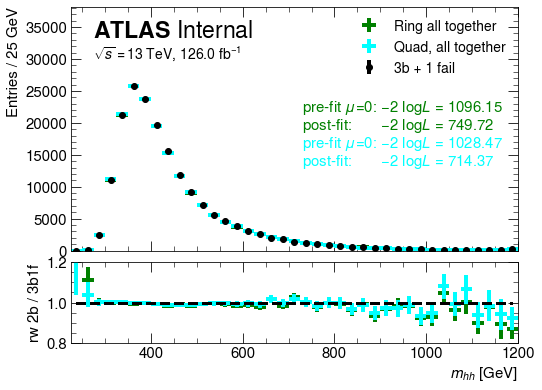

In [65]:
fig, ax = plt.subplots(2,1, figsize=(7.75, 5.92), sharex=True,
                       gridspec_kw={"height_ratios": [.75, .25], "hspace":0.07, 
                                    "left":0.098, "bottom":0.09})

ls = []
lc = []

for key, c, l in zip(['ring_all_39','quad_all_39'],['g','cyan'],
                     ['Ring all together','Quad, all together']):

    postfit_back = ests[key]['post0']
    postfit_err  = ests[key]['post_err']
    
    ax[0].errorbar(x_39,postfit_back,postfit_err,w_39/2,lw=0,elinewidth=4,color=c,label=l)
    ax[1].errorbar(x_39,postfit_back/obs,postfit_err/obs,w_39/2,lw=0,elinewidth=4,color=c)

    # Save the likelihoods
    pre_nll = ests[key]['pre_nll']
    nll = ests[key]['nll']
    ls.append(r'pre-fit $\mu$=0: $-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.2f}')
    ls.append(r'post-fit:       $-2 \  \log \mathcal{L}$ = '+f'{nll:.2f}')

    lc += [c]*2
    
ax[0].errorbar(x_39,obs,np.sqrt(obs),lw=0,elinewidth=4,color='k',label='3b + 1 fail',marker='o')


ax[1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
ax[1].set_ylabel('rw 2b / 3b1f')

ax[1].plot(x_39,np.ones_like(x_39),'k--')
ax[1].set_xlim(e_39[0],e_39[-1])
ax[1].set_ylim(.8,1.2)

ax[0].legend(loc='upper right')


'''
Make the plot purty
'''
ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
           va='center', ha='left', fontsize=23)

yr='all'
ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, %.1f fb$^{-1}$' % (lumi[yr]), transform=ax[0].transAxes,
        verticalalignment='center', horizontalalignment='left',
        fontsize=14)

ymax = ax[0].get_ylim()[1]
ax[0].set_ylim(0,1.4*ymax)

rainbow_text(720,ymax*.8,ls,lc,yoffset=1,ax=ax[0])
plt.savefig(f'{figDir}/postfit_m_hh_stackYrs_ring_v_quad.pdf',bbox_inches='tight')
plt.show()

**And now... w/ separate fits for each of the years**

In [66]:
ests.keys()

dict_keys(['ring_all_39', 'quad_all_39', 'ring_all_39_yrSep', 'quad_all_39_yrSep', 'ring_sep_39_yrSep', 'quad_sep_39_yrSep'])

In [67]:
obs16 = ests['ring_all_39_yrSep']['obs_16']
obs17 = ests['ring_all_39_yrSep']['obs_17']
obs18 = ests['ring_all_39_yrSep']['obs_18']

In [68]:
obs16

array([1.000e-20, 3.600e+01, 6.660e+02, 2.924e+03, 5.389e+03, 6.280e+03,
       5.642e+03, 4.658e+03, 3.574e+03, 2.733e+03, 2.119e+03, 1.635e+03,
       1.183e+03, 1.005e+03, 8.070e+02, 6.150e+02, 5.070e+02, 3.850e+02,
       2.840e+02, 2.630e+02, 2.400e+02, 1.740e+02, 1.360e+02, 1.260e+02,
       9.000e+01, 8.200e+01, 7.600e+01, 4.800e+01, 5.400e+01, 4.600e+01,
       2.600e+01, 3.300e+01, 1.700e+01, 1.600e+01, 1.600e+01, 7.000e+00,
       6.000e+00, 1.000e+01, 3.700e+01])

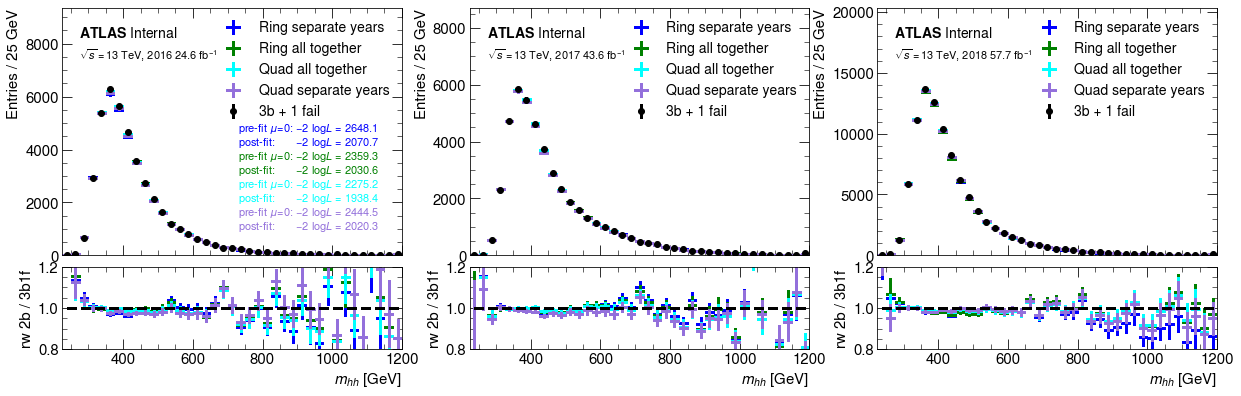

In [69]:
fig, axes = plt.subplots(2,3, figsize=(20, 6), sharex=True,
                       gridspec_kw={"height_ratios": [.75, .25], "hspace":0.07, 
                                    "left":0.098, "bottom":0.09})

lw = 2.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):

    ls = []
    lc = []

    for key, c, l in zip(['ring_sep_39_yrSep','ring_all_39_yrSep','quad_all_39_yrSep','quad_sep_39_yrSep'],
                         ['b','g','cyan','mediumpurple'],
                         ['Ring separate years','Ring all together','Quad all together','Quad separate years']):

        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(x_39,postfit_back,postfit_err,w_39/2,lw=0,elinewidth=lw,color=c,label=l)
        ax[1].errorbar(x_39,postfit_back/obs_i,postfit_err/obs_i,w_39/2,lw=0,elinewidth=lw,color=c)

        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'pre-fit $\mu$=0: $-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}')
        ls.append(r'post-fit:       $-2 \  \log \mathcal{L}$ = '+f'{nll:.1f}')

        lc += [c]*2

    ax[0].errorbar(x_39,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')


    ax[1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[1].set_ylabel('rw 2b / 3b1f')

    ax[1].plot(x_39,np.ones_like(x_39),'k--')
    ax[1].set_xlim(e_39[0],e_39[-1])
    ax[1].set_ylim(.8,1.2)

    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)

    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(720,ymax*.7,ls,lc,yoffset=1,ax=ax[0],fontsize=11)
        
#plt.savefig(f'{figDir}/postfit_m_hh_yrChan_ring_v_quad_sep.pdf',bbox_inches='tight')
plt.show()

Ok, v nice, I'll also break this up into separate ratio subpanels for each training to visualize this better :) 

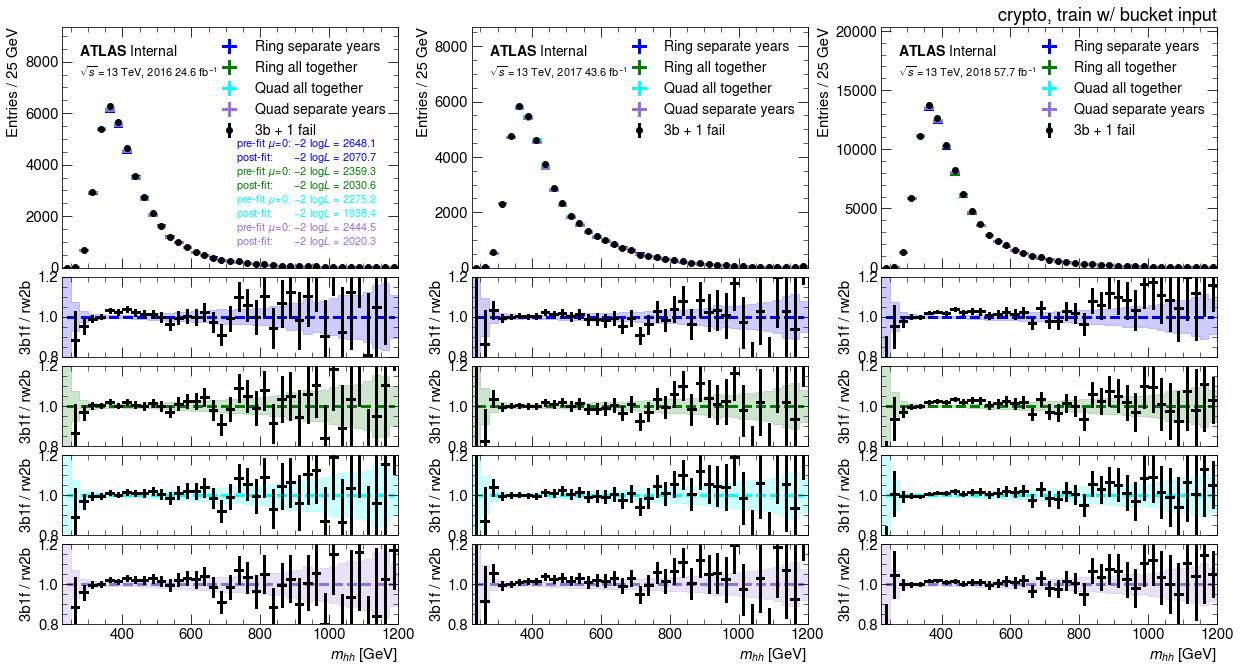

In [70]:
fig, axes = plt.subplots(5,3, figsize=(20, 10.5), sharex=True,
                         gridspec_kw={"height_ratios": [3/7, 1/7, 1/7, 1/7,1/7], 
                                      "hspace":0.08,"wspace":0.22,
                                      "left":0.098, "bottom":0.09})

lw = 2.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):

    ls = []
    lc = []

    for key, c, l,i in zip(['ring_sep_39_yrSep','ring_all_39_yrSep','quad_all_39_yrSep','quad_sep_39_yrSep'],
                           ['b','g','cyan','mediumpurple'],
                           ['Ring separate years','Ring all together','Quad all together','Quad separate years'],
                           range(4)):

        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(x_39,postfit_back,postfit_err,w_39/2,lw=0,elinewidth=lw,color=c,label=l)
        
        ax[i+1].errorbar(x_39,obs_i / postfit_back,np.sqrt(obs_i)/ postfit_back,
                         w_39/2,lw=0,elinewidth=lw,color='k',zorder=2)

        
        dn = np.concatenate(([1],(postfit_back-postfit_err)/postfit_back))
        up = np.concatenate(([1],(postfit_back+postfit_err)/postfit_back))
        ax[i+1].fill_between(e_39, dn, up, step="pre", color=c,alpha=0.2)
        ax[i+1].plot(x_39,np.ones_like(x_39),c,ls='--',zorder=1)
        
        ax[i+1].set_ylabel('3b1f / rw2b')
        
        ax[i+1].set_ylim(.8,1.2)
        
        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'pre-fit $\mu$=0: $-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}')
        ls.append(r'post-fit:       $-2 \  \log \mathcal{L}$ = '+f'{nll:.1f}')

        lc += [c]*2

    ax[0].errorbar(x_39,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')


    ax[-1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[0].set_xlim(e_39[0],e_39[-1])
    
    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)

    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(720,ymax*.7,ls,lc,yoffset=1,ax=ax[0],fontsize=11)

axes[0,-1].set_title('crypto, train w/ bucket input',loc='right')

plt.savefig(f'{figDir}/postfit_m_hh_yrChan_ring_v_quad_sep_rw_panel_qsep.pdf',bbox_inches='tight')
plt.show()

### Post-fit plot 2.0

Ok, so this is a great start, but I think the *next* order of business is now ***refining*** to accomodate the suggestions that  Max was making to me before 
1. For 3b1f, inflate the Poiss 2b error to better reflect the (expected) 4b stats
2. Include Chris's line on the plot
3. Update to variable width bins? 

**Plan:** For the *new* keys that I'll append, I'm j going to 

In [15]:
ests = {}

In [16]:
base_name = '../stats-results/ggF_PUSH/ws-3b1f-systs-{}-bkg-0.1-16-17-18-SM-HH-unblind-{}_res_p05_nomSR.json'

for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT','Q45','Q45_OHE']:
    for syst, si in zip(['HTcut-300.0','m_h1cut-124.0-m_h2cut-117.0'],['ht','qs']):
        ws_name = base_name.format(syst,key)
        ests[f'{key}_{si}'] = get_est(ws_name)


W VariableMetricBuilder No free parameters.


/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py:130: IMinuitWarning: HESSE called with all parameters fixed
  minimizer.hesse()


W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.


In [17]:
ests.keys()

dict_keys(['RSEP_ht', 'RSEP_qs', 'ROHE_ht', 'ROHE_qs', 'QOHE_ht', 'QOHE_qs', 'QSEP_ht', 'QSEP_qs', 'QSEP_CG_ht', 'QSEP_CG_qs', 'QTILT_ht', 'QTILT_qs', 'Q45_ht', 'Q45_qs', 'Q45_OHE_ht', 'Q45_OHE_qs'])

In [18]:
obs16 = ests['RSEP_ht']['obs_16']
obs17 = ests['RSEP_ht']['obs_17']
obs18 = ests['RSEP_ht']['obs_18']

In [19]:
ests['RSEP_ht']['obs_16']

array([ 23.2,  67.7, 162.6, 278.1, 395.8, 453.6, 436.2, 401.5, 359.4,
       297.4, 256.4, 209.3, 173.8, 142.5, 109.9,  91. ,  75. ,  59. ,
        42.1,  38.4,  30.4,  22.5,  18.4,  13.9,  10.2,   9.1,   6.1,
        11. ])

In [20]:
e_p05 = np.array([275, 289, 303, 318, 334, 351, 369, 387, 406, 426, 447, 469, 492, 
                  517, 543, 570, 598, 628, 659, 692, 727, 763, 801, 841, 883, 927, 
                  973, 1022, 1073])

In [21]:
xx = 0.5 * (e_p05[1:] + e_p05[:-1])
w = e_p05[1:] - e_p05[:-1]

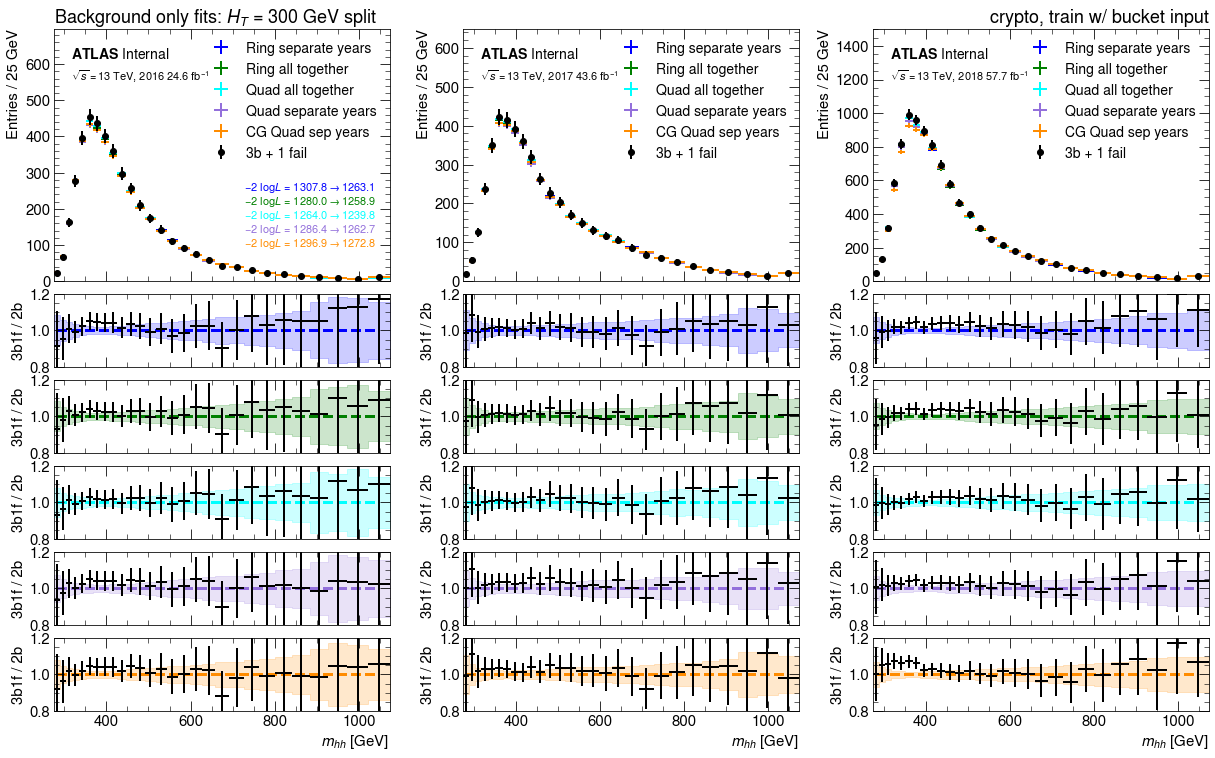

In [22]:
fig, axes = plt.subplots(6,3, figsize=(20, 12), sharex=True,
                         gridspec_kw={"height_ratios": [3/7, 1/8, 1/8, 1/8,1/8,1/8], 
                                      "hspace":0.12,"wspace":0.22,
                                      "left":0.098, "bottom":0.09})

lw = 1.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):


    ls = []
    lc = []

    for k, c,l,i in zip(['RSEP','ROHE','QOHE','QSEP','QSEP_CG'],['b','g','cyan','mediumpurple','darkorange'],
                        ['Ring separate years','Ring all together','Quad all together',
                         'Quad separate years','CG Quad sep years'], range(5)):

        key = f'{k}_ht'
        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(xx,postfit_back,postfit_err,w/2,lw=0,elinewidth=lw,color=c,label=l)
        
        ax[i+1].errorbar(xx,obs_i / postfit_back,np.sqrt(obs_i)/ postfit_back,
                         w/2,lw=0,elinewidth=lw,color='k',zorder=2)

        
        dn = np.concatenate(([1],(postfit_back-postfit_err)/postfit_back))
        up = np.concatenate(([1],(postfit_back+postfit_err)/postfit_back))
        ax[i+1].fill_between(e_p05, dn, up, step="pre", color=c,alpha=0.2)
        ax[i+1].plot(xx,np.ones_like(xx),c,ls='--',zorder=1)
        
        ax[i+1].set_ylabel('3b1f / 2b')
        
        ax[i+1].set_ylim(.8,1.2)
        
        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'$-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}' + r'$\rightarrow$' +f'{nll:.1f}')

        lc += [c]

    ax[0].errorbar(xx,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')

    ax[-1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[0].set_xlim(e_p05[0],e_p05[-1])
    
    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)
    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(720,ymax*.5,ls,lc,yoffset=1,ax=ax[0],fontsize=11)

axes[0,0].set_title('Background only fits: $H_T$ = 300 GeV split',loc='left')
axes[0,-1].set_title('crypto, train w/ bucket input',loc='right')

plt.savefig(f'{figDir}/postfit_m_hh_res_p05_HT_split.pdf',bbox_inches='tight')
plt.show()

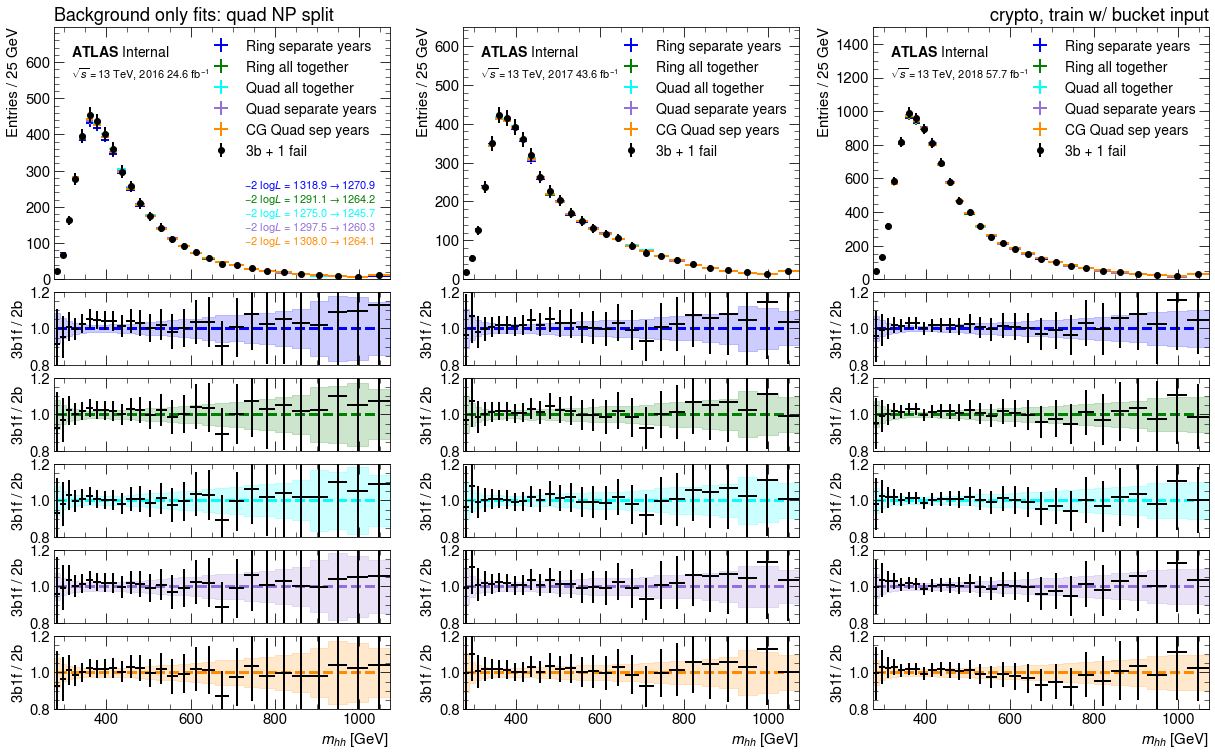

In [79]:
fig, axes = plt.subplots(6,3, figsize=(20, 12), sharex=True,
                         gridspec_kw={"height_ratios": [3/7, 1/8, 1/8, 1/8,1/8,1/8], 
                                      "hspace":0.12,"wspace":0.22,
                                      "left":0.098, "bottom":0.09})

lw = 1.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):


    ls = []
    lc = []

    for k, c,l,i in zip(['RSEP','ROHE','QOHE','QSEP','QSEP_CG'],['b','g','cyan','mediumpurple','darkorange'],
                        ['Ring separate years','Ring all together','Quad all together',
                         'Quad separate years','CG Quad sep years'], range(5)):

        key = f'{k}_qs'
        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(xx,postfit_back,postfit_err,w/2,lw=0,elinewidth=lw,color=c,label=l)
        
        ax[i+1].errorbar(xx,obs_i / postfit_back,np.sqrt(obs_i)/ postfit_back,
                         w/2,lw=0,elinewidth=lw,color='k',zorder=2)

        
        dn = np.concatenate(([1],(postfit_back-postfit_err)/postfit_back))
        up = np.concatenate(([1],(postfit_back+postfit_err)/postfit_back))
        ax[i+1].fill_between(e_p05, dn, up, step="pre", color=c,alpha=0.2)
        ax[i+1].plot(xx,np.ones_like(xx),c,ls='--',zorder=1)
        
        ax[i+1].set_ylabel('3b1f / 2b')
        
        ax[i+1].set_ylim(.8,1.2)
        
        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'$-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}' + r'$\rightarrow$' +f'{nll:.1f}')

        lc += [c]

    ax[0].errorbar(xx,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')

    ax[-1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[0].set_xlim(e_p05[0],e_p05[-1])
    
    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)
    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(720,ymax*.5,ls,lc,yoffset=1,ax=ax[0],fontsize=11)

axes[0,0].set_title('Background only fits: quad NP split',loc='left')
axes[0,-1].set_title('crypto, train w/ bucket input',loc='right')

plt.savefig(f'{figDir}/postfit_m_hh_res_p05_quad_NPs.pdf',bbox_inches='tight')
plt.show()

**Include titled ellipse line from Chris too**

In [80]:
12/8

1.5

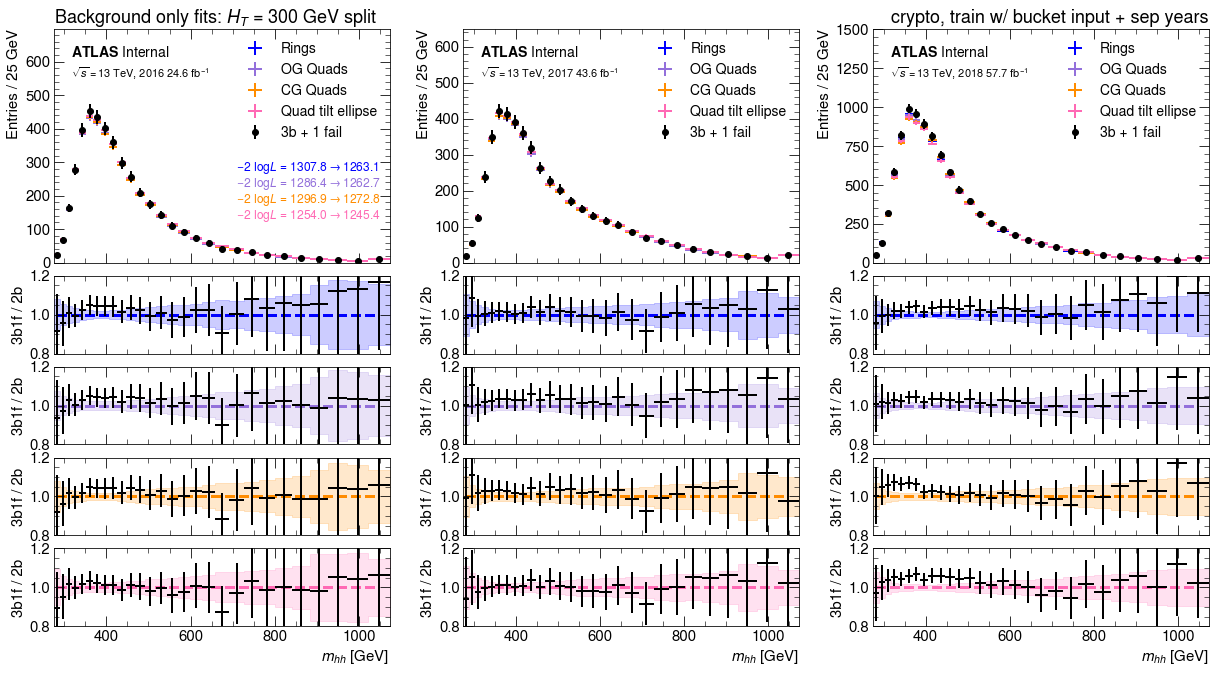

In [81]:
fig, axes = plt.subplots(5,3, figsize=(20, 10.5), sharex=True,
                         gridspec_kw={"height_ratios": [3/7, 1/7,1/7,1/7,1/7], 
                                      "hspace":0.12,"wspace":0.22,
                                      "left":0.098, "bottom":0.09})

lw = 1.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):


    ls = []
    lc = []

    for k, c,l,i in zip(['RSEP','QSEP','QSEP_CG','QTILT'],
                        ['b','mediumpurple','darkorange','hotpink'],
                        ['Rings','OG Quads','CG Quads','Quad tilt ellipse'], range(6)):

        key = f'{k}_ht'
        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(xx,postfit_back,postfit_err,w/2,lw=0,elinewidth=lw,color=c,label=l)
        
        ax[i+1].errorbar(xx,obs_i / postfit_back,np.sqrt(obs_i)/ postfit_back,
                         w/2,lw=0,elinewidth=lw,color='k',zorder=2)

        
        dn = np.concatenate(([1],(postfit_back-postfit_err)/postfit_back))
        up = np.concatenate(([1],(postfit_back+postfit_err)/postfit_back))
        ax[i+1].fill_between(e_p05, dn, up, step="pre", color=c,alpha=0.2)
        ax[i+1].plot(xx,np.ones_like(xx),c,ls='--',zorder=1)
        
        ax[i+1].set_ylabel('3b1f / 2b')
        
        ax[i+1].set_ylim(.8,1.2)
        
        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'$-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}' + r'$\rightarrow$' +f'{nll:.1f}')

        lc += [c]

    ax[0].errorbar(xx,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')

    ax[-1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[0].set_xlim(e_p05[0],e_p05[-1])
    
    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)
    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(700,ymax*.55,ls,lc,yoffset=1,ax=ax[0],fontsize=12)

axes[0,0].set_title('Background only fits: $H_T$ = 300 GeV split',loc='left')
axes[0,-1].set_title('crypto, train w/ bucket input + sep years',loc='right')

plt.savefig(f'{figDir}/postfit_m_hh_res_p05_HT_split_withTilt.pdf',bbox_inches='tight')
plt.show()

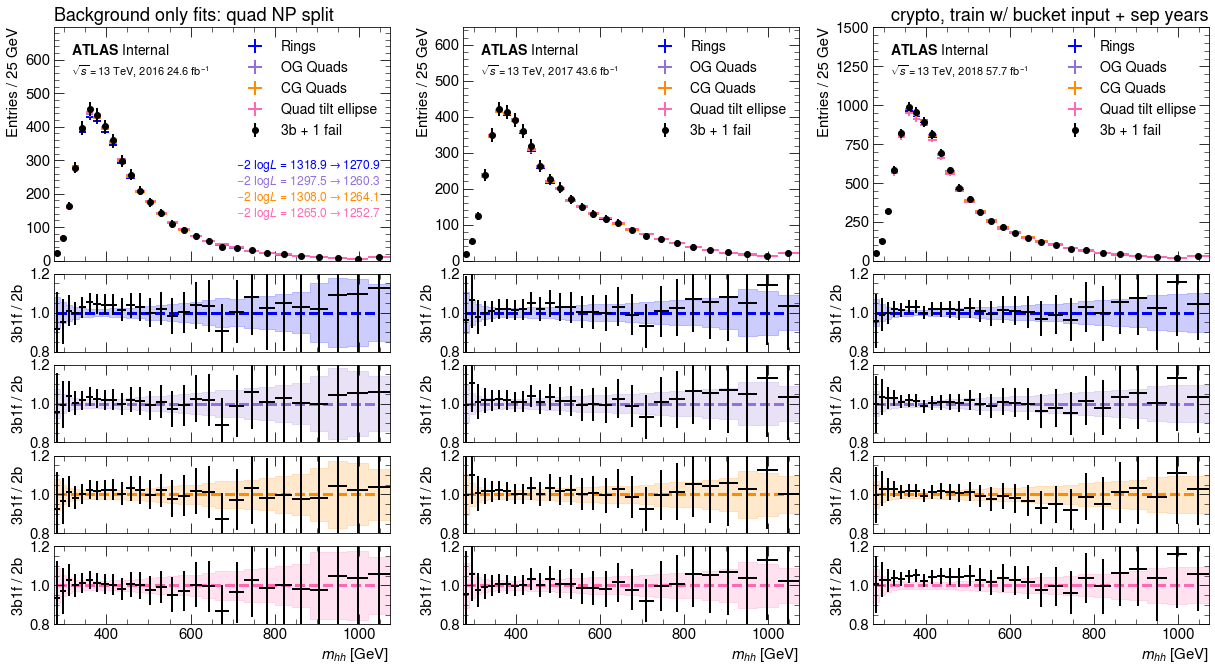

In [82]:
fig, axes = plt.subplots(5,3, figsize=(20, 10.5), sharex=True,
                         gridspec_kw={"height_ratios": [3/7, 1/7,1/7,1/7,1/7], 
                                      "hspace":0.12,"wspace":0.22,
                                      "left":0.098, "bottom":0.09})

lw = 1.5
for ax,yr,obs_i in zip(axes.T,[16,17,18],[obs16,obs17,obs18]):


    ls = []
    lc = []

    for k, c,l,i in zip(['RSEP','QSEP','QSEP_CG','QTILT'],
                        ['b','mediumpurple','darkorange','hotpink'],
                        ['Rings','OG Quads','CG Quads','Quad tilt ellipse'], range(6)):

        key = f'{k}_qs'
        postfit_back = ests[key][f'post0_{yr}']
        postfit_err  = ests[key][f'post_err_{yr}']

        ax[0].errorbar(xx,postfit_back,postfit_err,w/2,lw=0,elinewidth=lw,color=c,label=l)
        
        ax[i+1].errorbar(xx,obs_i / postfit_back,np.sqrt(obs_i)/ postfit_back,
                         w/2,lw=0,elinewidth=lw,color='k',zorder=2)

        
        dn = np.concatenate(([1],(postfit_back-postfit_err)/postfit_back))
        up = np.concatenate(([1],(postfit_back+postfit_err)/postfit_back))
        ax[i+1].fill_between(e_p05, dn, up, step="pre", color=c,alpha=0.2)
        ax[i+1].plot(xx,np.ones_like(xx),c,ls='--',zorder=1)
        
        ax[i+1].set_ylabel('3b1f / 2b')
        
        ax[i+1].set_ylim(.8,1.2)
        
        # Save the likelihoods
        pre_nll = ests[key]['pre_nll']
        nll = ests[key]['nll']
        ls.append(r'$-2 \  \log \mathcal{L}$ = '+f'{pre_nll:.1f}' + r'$\rightarrow$' +f'{nll:.1f}')

        lc += [c]

    ax[0].errorbar(xx,obs_i,np.sqrt(obs_i),lw=0,elinewidth=lw,color='k',label='3b + 1 fail',marker='o')

    ax[-1].set_xlabel('$m_{hh}$ [GeV]',x=1,ha='right')
    ax[0].set_ylabel('Entries / 25 GeV',y=1,ha='right')
    ax[0].set_xlim(e_p05[0],e_p05[-1])
    
    ax[0].legend(loc='upper right')

    ax[0].text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax[0].transAxes,
               va='center', ha='left', fontsize=14)
    ax[0].text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, 20%d %.1f fb$^{-1}$' % (yr,lumi[str(yr)]), transform=ax[0].transAxes,
            verticalalignment='center', horizontalalignment='left',
            fontsize=11)

    ymax = ax[0].get_ylim()[1]
    ax[0].set_ylim(0,1.4*ymax)
    if yr == 16:
        rainbow_text(700,ymax*.55,ls,lc,yoffset=1,ax=ax[0],fontsize=12)

axes[0,0].set_title('Background only fits: quad NP split',loc='left')
axes[0,-1].set_title('crypto, train w/ bucket input + sep years',loc='right')

plt.savefig(f'{figDir}/postfit_m_hh_res_p05_quad_NPs_withTilt.pdf',bbox_inches='tight')
plt.show()

### Post-fit 3.0

What are we excited about now???

*inclusive trainings with the tiltie-titl* :)

## Step 2: Pulls

**Plan:** Sean has a *script* for this too! (I think I might j call this script here :) )

In [83]:
# Change directory to non-resonant
os.chdir('../non-resonant-studies/')

for ws_in in glob('../stats-results/ggF_PUSH/ws-3b1f-systs-*-bkg-0.1-16-17-18-SM-HH-unblind-*_res_p05_nomSR.json'):

    for op,tag in zip(['','--bkgd-only'],['','_b_only']):
        
        cmd = f'python run_pulls.py -i {ws_in} --pulls {op}'

        if not os.path.exists(ws_in.replace('.json',f'{tag}_pulls.csv')):
            print(cmd)
            os.system(cmd)
            
# cd back here to avoid fucking up the plotting scripts :)
os.chdir('../cryptotuples/')

python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-m_h1cut-124.0-m_h2cut-117.0-bkg-0.1-16-17-18-SM-HH-unblind-Q60_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-m_h1cut-124.0-m_h2cut-117.0-bkg-0.1-16-17-18-SM-HH-unblind-Q60_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-bkg-0.1-16-17-18-SM-HH-unblind-Q30_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-bkg-0.1-16-17-18-SM-HH-unblind-Q30_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-m_h1cut-124.0-m_h2cut-117.0-bkg-0.1-16-17-18-SM-HH-unblind-Q30_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-m_h1cut-124.0-m_h2cut-117.0-bkg-0.1-16-17-18-SM-HH-unblind-Q30_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-3b1f-systs-HTcut-300.0-

In [84]:
# Change directory to non-resonant
os.chdir('../non-resonant-studies/')

for ws_in in glob('../stats-results/ggF_PUSH/ws-4b-systs-*-16-17-18-SM-HH-*_res_p05_nomSR.json'):

    for op,tag in zip(['','--bkgd-only'],['','_b_only']):
        
        cmd = f'python run_pulls.py -i {ws_in} --pulls {op}'

        if not os.path.exists(ws_in.replace('.json',f'{tag}_pulls.csv')):
            print(cmd)
            os.system(cmd)
            

# cd back here to avoid fucking up the plotting scripts :)
os.chdir('../cryptotuples/')

python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-HTcut-300.0-16-17-18-SM-HH-Q30_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-HTcut-300.0-16-17-18-SM-HH-Q30_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-m_h1cut-124.0-m_h2cut-117.0-16-17-18-SM-HH-Q45_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-m_h1cut-124.0-m_h2cut-117.0-16-17-18-SM-HH-Q45_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-HTcut-300.0-16-17-18-SM-HH-Q45_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-HTcut-300.0-16-17-18-SM-HH-Q45_res_p05_nomSR.json --pulls --bkgd-only
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-m_h1cut-124.0-m_h2cut-117.0-16-17-18-SM-HH-Q60_res_p05_nomSR.json --pulls 
python run_pulls.py -i ../stats-results/ggF_PUSH/ws-4b-systs-m_h1cut-124.0-m_h2

In [85]:
pulls_3b1f_bOnly   = {}
pulls_3b1f   = {}


for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT']:
    for syst, si in zip(['HTcut-300.0','m_h1cut-124.0-m_h2cut-117.0'],['ht','qs']):
        
    
        # 3b1f: b-only
        ws_in = base_name.format(syst,key)
        dfi = pd.read_csv(ws_in.replace('.json','_b_only_pulls.csv'))
        
        pulls_3b1f_bOnly[f'{key}_{si}'] = dfi
        
        # 3b1f: s+b
        ws_in = base_name.format(syst,key)
        dfi = pd.read_csv(ws_in.replace('.json','_pulls.csv'))
        
        pulls_3b1f[f'{key}_{si}'] = dfi

In [86]:
name_4b = '../stats-results/ggF_PUSH/ws-4b-systs-{}-16-17-18-SM-HH-{}_res_p05_nomSR.json'

pulls_4b_bOnly   = {}
pulls_4b   = {}

for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT']:
    for syst, si in zip(['HTcut-300.0','m_h1cut-124.0-m_h2cut-117.0'],['ht','qs']):
        
    
        # 3b1f: b-only
        ws_in = name_4b.format(syst,key)
        dfi = pd.read_csv(ws_in.replace('.json','_b_only_pulls.csv'))
        
        pulls_4b_bOnly[f'{key}_{si}'] = dfi
        
        # 3b1f: s+b
        ws_in = base_name.format(syst,key)
        dfi = pd.read_csv(ws_in.replace('.json','_pulls.csv'))
        
        pulls_4b[f'{key}_{si}'] = dfi

**Borrowing from some previously existing things...**

**What am I looking at?**


- 6 NPs or 12 NPs


(Ofc could *also* be interesting to look at the BS pull plot to see if anything is getting compensated for?)

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/ticker.py:2957: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


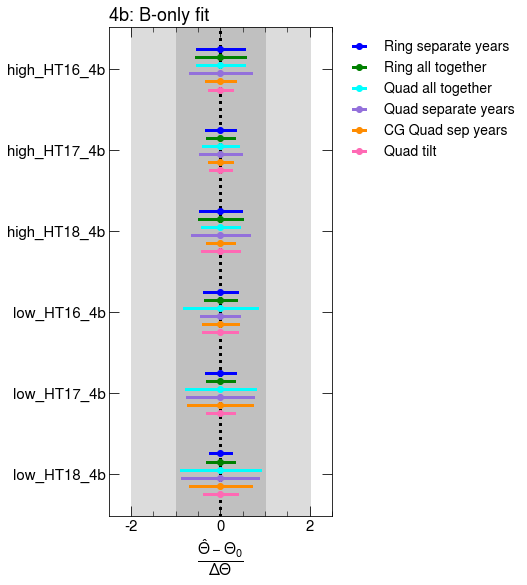

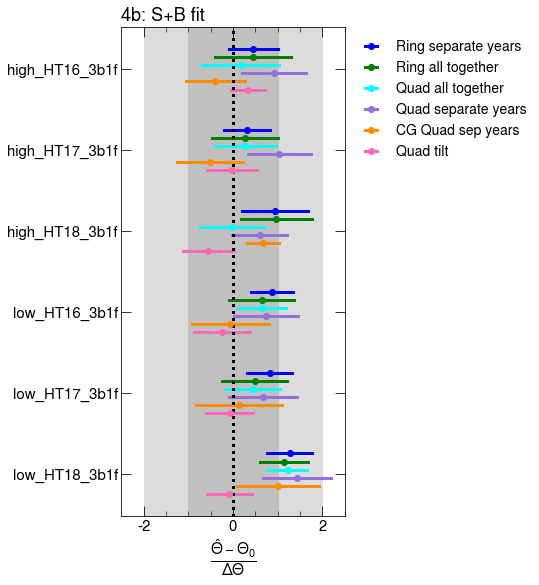

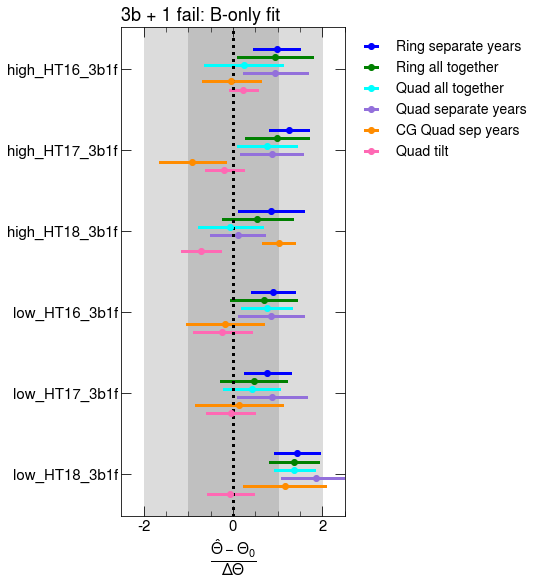

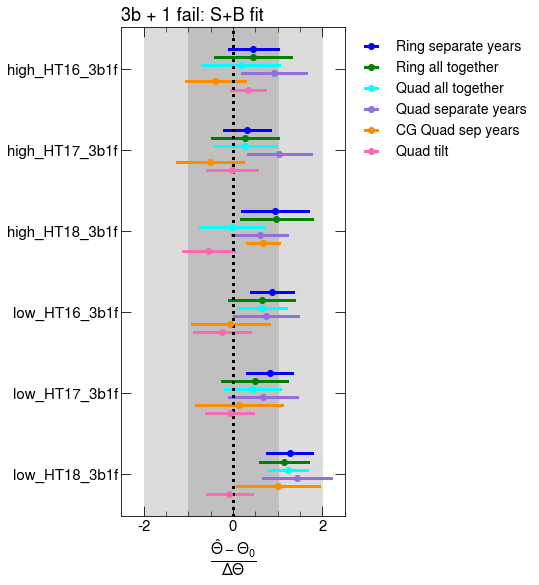

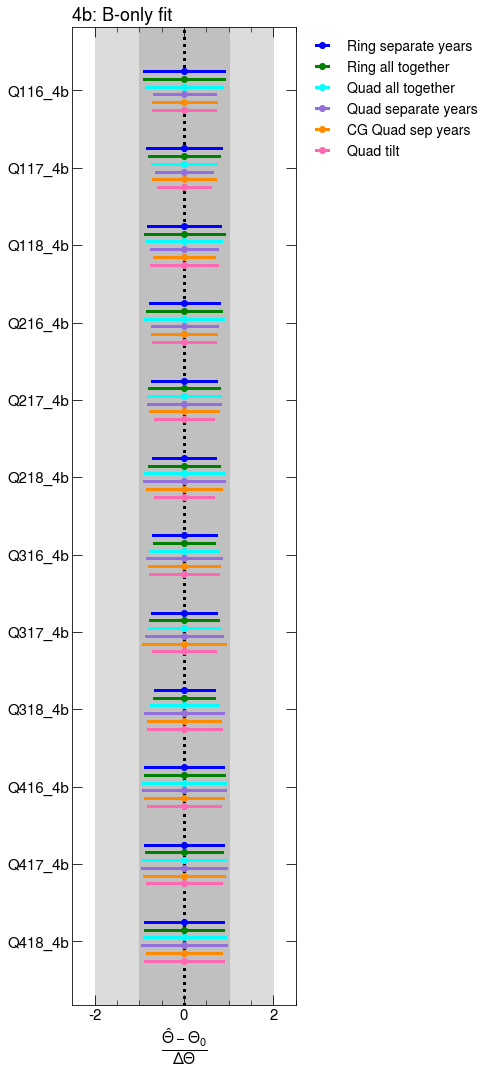

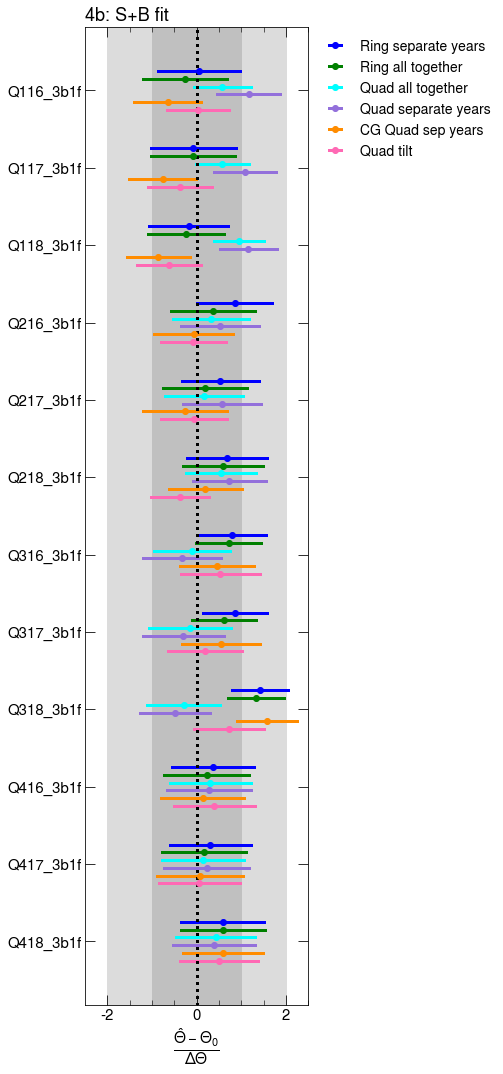

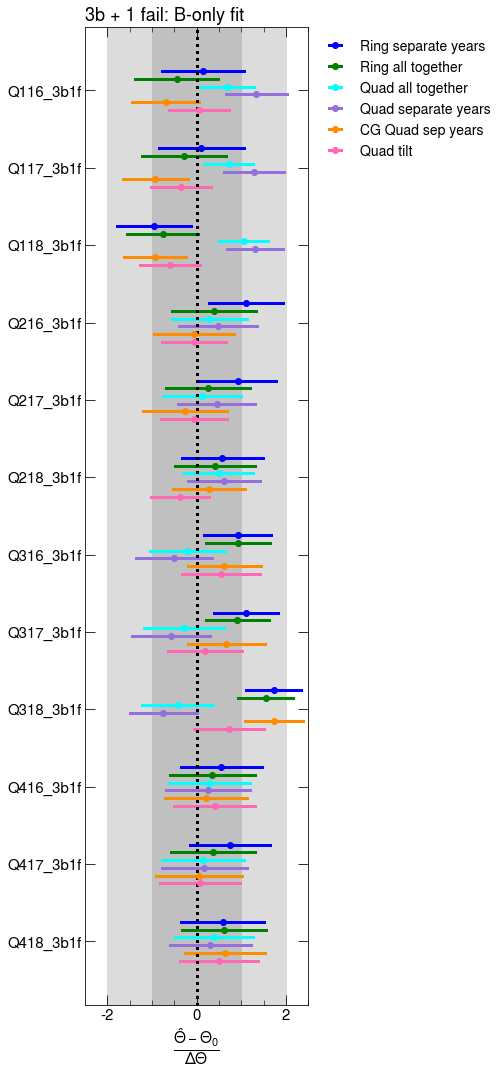

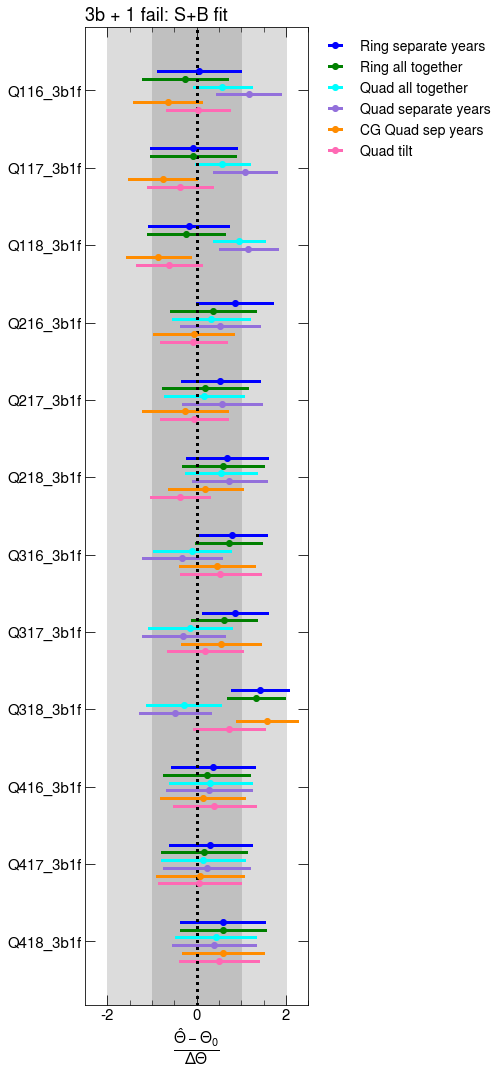

In [87]:
for split, si, nNPs in zip(['HT_split','quad_NP'],['ht','qs'],[6,12]):
    
    ys = np.arange(nNPs,0,-1)

    dx = .1

    for pulls,bcat,bl,label,tag in zip([pulls_4b_bOnly,pulls_4b,pulls_3b1f_bOnly,pulls_3b1f],
                                       ['4b']*2+['3b1f']*2,['4b']*2+['3b + 1 fail']*2,
                                       ['B-only fit', 'S+B fit']*2,['Bonly','S+B']*2):

        plt.figure(figsize=(4,1.5*nNPs))

        for k, color,l,i in zip(['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT'],
                                ['b','g','cyan','mediumpurple','darkorange','hotpink'],
                                ['Ring separate years','Ring all together','Quad all together',
                                 'Quad separate years','CG Quad sep years','Quad tilt'], range(6)):

            df = pulls[f'{k}_{si}']
            plt.errorbar(df[:nNPs].pull,ys + (2.5-i)*dx,xerr=df[:nNPs].err,label=l,
                         marker='o',color=color,lw=0,elinewidth=3)

        ylim = plt.ylim()
        plt.fill_betweenx(ylim,-2,2,color='gainsboro')
        plt.fill_betweenx(ylim,-1,1,color='silver')


        plt.xlabel(r'$\frac{\hat{\Theta} - \Theta_0}{\Delta \Theta}$',fontsize=22)
        plt.title(f'{bl}: {label}',loc='left')
        plt.legend(bbox_to_anchor=(1,1.0))

        plt.yticks(ys,df.label[:nNPs])
        ax = plt.gca()
        ax.tick_params(axis='y',which='minor', length=0)

        plt.plot([0]*2,ylim,'k',ls='dotted')#

        plt.xlim(-2.5,2.5)
        plt.ylim(ylim)

        plt.savefig(f'{figDir}/pulls_{bcat}_{si}_{tag}_tilt.pdf',bbox_inches='tight')

    plt.show()

### Next: Let's c.f. the "limits" that get spit out

In [2]:
idx = ['stat-only (BS)','None','HT = 300 split','quad NPs']
cols = ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT']

lim_4b = pd.DataFrame(0, index=idx,columns=cols)

In [3]:
lim_4b

RSEP  ROHE  QOHE  QSEP  QSEP_CG  QTILT
stat-only (BS)     0     0     0     0        0      0
None               0     0     0     0        0      0
HT = 300 split     0     0     0     0        0      0
quad NPs           0     0     0     0        0      0

In [4]:
systs = [
    'stat-only',
    'stat-only-noBS',
    'systs-HTcut-300.0',
    'systs-m_h1cut-124.0-m_h2cut-117.0'
]

In [8]:
lim_name = '../stats-results/ggF_PUSH/lim-4b-{}-16-17-18-SM-HH-{}_res_p05_nomSR.csv'

for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT','Q30','Q45','Q60','Q45_OHE']:
    for syst, si in zip(systs,idx):
        dfi = pd.read_csv(lim_name.format(syst,key))
        lim_4b.loc[si,key] = dfi.Exp[0]

In [9]:
lim_4b.round(2)

RSEP  ROHE   QOHE  QSEP  QSEP_CG  QTILT   Q30   Q45   Q60  \
stat-only (BS)  7.26  7.23   7.42  7.31     7.20   7.25  7.15  7.14  7.26   
None            6.61  6.71   6.83  6.67     6.66   6.66  6.66  6.63  6.76   
HT = 300 split  8.47  8.67  10.01  7.64     8.42   8.76  8.48  8.05  9.92   
quad NPs        8.12  8.00   9.29  7.99     8.41   8.31  8.11  7.83  8.94   

                Q45_OHE  
stat-only (BS)     7.60  
None               6.79  
HT = 300 split     8.91  
quad NPs           8.55

In [11]:
lim_4b[['RSEP', 'ROHE', 'QSEP',  'QOHE', 'Q45','Q45_OHE']].round(2)

RSEP  ROHE  QSEP   QOHE   Q45  Q45_OHE
stat-only (BS)  7.26  7.23  7.31   7.42  7.14     7.60
None            6.61  6.71  6.67   6.83  6.63     6.79
HT = 300 split  8.47  8.67  7.64  10.01  8.05     8.91
quad NPs        8.12  8.00  7.99   9.29  7.83     8.55

In [93]:
lim_3b1f = {k: pd.DataFrame(0, index=idx[2:],columns=cols) for k in dfi.columns}

In [94]:
lim_name = '../stats-results/ggF_PUSH/lim-3b1f-{}-bkg-0.1-16-17-18-SM-HH-unblind-{}_res_p05_nomSR.csv'

for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT']:
    for syst, si in zip(systs[2:],idx[2:]):
        dfi = pd.read_csv(lim_name.format(syst,key))
        
        for k in dfi.columns:
        
            lim_3b1f[k].loc[si,key] = dfi[k][0]

In [95]:
lumi['all'] = lumi['16'] + lumi['17'] + lumi['18']

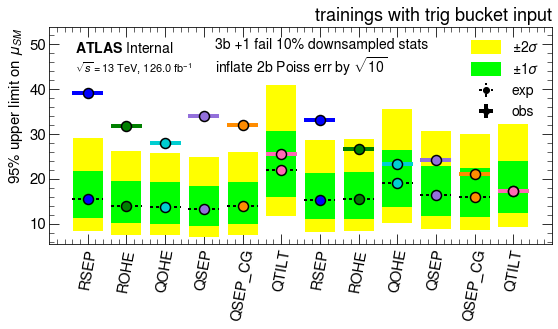

In [96]:
# c = 'shape + bootstrap'
# tag = 'shape_bs'

plt.figure(figsize=(9,4))


two_sigma = np.vstack([lim_3b1f['Exp'].values.flatten()- lim_3b1f['-2s'].values.flatten(), 
                       lim_3b1f['2s'].values.flatten()-lim_3b1f['Exp'].values.flatten()])
one_sigma = np.vstack([lim_3b1f['Exp'].values.flatten()- lim_3b1f['-1s'].values.flatten(), 
                       lim_3b1f['1s'].values.flatten()-lim_3b1f['Exp'].values.flatten()])

plt.errorbar(range(12), lim_3b1f['Exp'].values.flatten(), two_sigma , color='yellow',
             lw=0,elinewidth=30,label=r'$\pm 2 \sigma$')
plt.errorbar(range(12), lim_3b1f['Exp'].values.flatten(), one_sigma ,color='lime',
             lw=0,elinewidth=30,label=r'$\pm 1 \sigma$')


for i,k,c in zip(range(6),lim_3b1f['Exp'].columns,['b','g','darkturquoise','mediumpurple','darkorange','hotpink']):
    eb0 = plt.errorbar([i,i+6], lim_3b1f['Exp'][k], 0, .4, 
                       marker='o',color=c,lw=0,markersize=10,
                       elinewidth=2,ecolor='k',
                       markeredgewidth=1.5, markeredgecolor='k')
    eb0[-1][0].set_linestyle('dotted')
    plt.errorbar([i,i+6], lim_3b1f['Obs'][k], 0, .4, 
                 marker='o',color=c,lw=0,markersize=10,
                 markeredgewidth=1.5, markeredgecolor='k',
                 elinewidth=4)

eb0 = plt.errorbar([], [], 0, .4, label='exp',
                   marker='o',color='k',lw=0,#markersize=10,
                   elinewidth=2)
eb0[-1][0].set_linestyle('dotted')
plt.errorbar([], [], 0, .4, label='obs',
             marker='o',color='k',lw=0,elinewidth=4)
    
    
# plt.legend(loc='upper right')
plt.xticks(range(12),list(lim_3b1f['Exp'].columns)*2,rotation=80)
plt.ylabel('95% upper limit on $\mu_{SM}$',y=1,ha='right')
plt.title('trainings with trig bucket input',loc='right')
plt.legend(loc='upper right')

ymin,ymax = plt.ylim()
plt.ylim(ymin,ymax + .3*(ymax-ymin))


ax = plt.gca()
plt.text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax.transAxes,
               va='center', ha='left', fontsize=14)

plt.text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, %.1f fb$^{-1}$' % (lumi['all']),
         transform=ax.transAxes,va='center', ha='left',fontsize=11)

plt.text(0.33, 0.95, '3b +1 fail 10% downsampled stats\ninflate 2b Poiss err by $\sqrt{10}$',
         transform=ax.transAxes,va='top', ha='left',fontsize=14)

plt.savefig(f'{figDir}/lim_3b1f.pdf',bbox_inches='tight')

**Q:** Does the agreement get any better if we *also* include the BS error?

In [97]:
lim_3b1f_bs = {k: pd.DataFrame(0, index=idx[2:],columns=cols) for k in dfi.columns}

In [98]:
lim_name = '../stats-results/ggF_PUSH/lim-3b1f-{}-bkg-0.1-bsInf-0.1-16-17-18-SM-HH-unblind-{}_res_p05_nomSR.csv'

for key in ['RSEP', 'ROHE', 'QOHE', 'QSEP', 'QSEP_CG','QTILT']:
    for syst, si in zip(systs[2:],idx[2:]):
        dfi = pd.read_csv(lim_name.format(syst,key))
        
        for k in dfi.columns:
        
            lim_3b1f_bs[k].loc[si,key] = dfi[k][0]

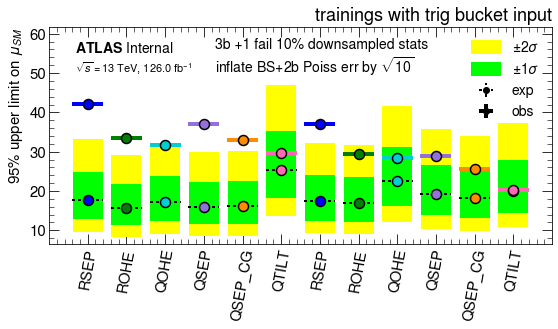

In [99]:
plt.figure(figsize=(9,4))


two_sigma = np.vstack([lim_3b1f_bs['Exp'].values.flatten()- lim_3b1f_bs['-2s'].values.flatten(), 
                       lim_3b1f_bs['2s'].values.flatten()-lim_3b1f_bs['Exp'].values.flatten()])
one_sigma = np.vstack([lim_3b1f_bs['Exp'].values.flatten()- lim_3b1f_bs['-1s'].values.flatten(), 
                       lim_3b1f_bs['1s'].values.flatten()-lim_3b1f_bs['Exp'].values.flatten()])

plt.errorbar(range(12), lim_3b1f_bs['Exp'].values.flatten(), two_sigma , color='yellow',
             lw=0,elinewidth=30,label=r'$\pm 2 \sigma$')
plt.errorbar(range(12), lim_3b1f_bs['Exp'].values.flatten(), one_sigma ,color='lime',
             lw=0,elinewidth=30,label=r'$\pm 1 \sigma$')


for i,k,c in zip(range(6),lim_3b1f_bs['Exp'].columns,
                 ['b','g','darkturquoise','mediumpurple','darkorange','hotpink']):
    eb0 = plt.errorbar([i,i+6], lim_3b1f_bs['Exp'][k], 0, .4, 
                       marker='o',color=c,lw=0,markersize=10,
                       elinewidth=2,ecolor='k',
                       markeredgewidth=1.5, markeredgecolor='k')
    eb0[-1][0].set_linestyle('dotted')
    plt.errorbar([i,i+6], lim_3b1f_bs['Obs'][k], 0, .4, 
                 marker='o',color=c,lw=0,markersize=10,
                 markeredgewidth=1.5, markeredgecolor='k',
                 elinewidth=4)

eb0 = plt.errorbar([], [], 0, .4, label='exp',
                   marker='o',color='k',lw=0,#markersize=10,
                   elinewidth=2)
eb0[-1][0].set_linestyle('dotted')
plt.errorbar([], [], 0, .4, label='obs',
             marker='o',color='k',lw=0,elinewidth=4)
    
    
# plt.legend(loc='upper right')
plt.xticks(range(12),list(lim_3b1f['Exp'].columns)*2,rotation=80)
plt.ylabel('95% upper limit on $\mu_{SM}$',y=1,ha='right')
plt.title('trainings with trig bucket input',loc='right')
plt.legend(loc='upper right')

ymin,ymax = plt.ylim()
plt.ylim(ymin,ymax + .3*(ymax-ymin))


ax = plt.gca()
plt.text(0.05, 0.9, "$\mathbf{ATLAS}$ Internal", transform=ax.transAxes,
               va='center', ha='left', fontsize=14)

plt.text(0.05, 0.81, '$\\sqrt{s} = 13$ TeV, %.1f fb$^{-1}$' % (lumi['all']),
         transform=ax.transAxes,va='center', ha='left',fontsize=11)

plt.text(0.33, 0.95, '3b +1 fail 10% downsampled stats\ninflate BS+2b Poiss err by $\sqrt{10}$',
         transform=ax.transAxes,va='top', ha='left',fontsize=14)

plt.savefig(f'{figDir}/lim_3b1f_bsInf.pdf',bbox_inches='tight')

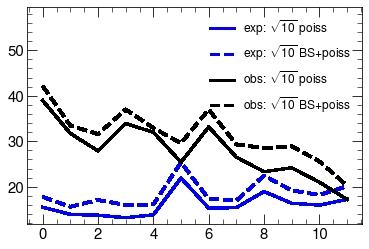

In [103]:
plt.plot(lim_3b1f['Exp'].values.flatten(),color='b',ls='-',label='exp: $\sqrt{10}$ poiss')
plt.plot(lim_3b1f_bs['Exp'].values.flatten(),color='b',ls='--',label='exp: $\sqrt{10}$ BS+poiss')

plt.plot(lim_3b1f['Obs'].values.flatten(),color='k',ls='-',label='obs: $\sqrt{10}$ poiss')
plt.plot(lim_3b1f_bs['Obs'].values.flatten(),color='k',ls='--',label='obs: $\sqrt{10}$ BS+poiss')

ymin,ymax = plt.ylim()
plt.ylim(ymin, ymin + 1.5*(ymax-ymin))

plt.legend(fontsize=12)

plt.savefig(f'{figDir}/lim_3b1f_obs_exp.pdf')
plt.show()

**Conclusion:** Inflating the BS error *degrades* the limit, but does *not* improve the agreement (it seems)

I'm honestly quite worried about these optimizations, whether we're doing smth reasonable or not?